<a href="https://colab.research.google.com/github/dsogden/Quantitative_Finance/blob/main/Beta_Hedging_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [2]:
start = '2020-01-01'
end = '2022-06-01'

tickers = ['A', 'GOOG', 'MRO']
asset = yf.download(tickers, start=start, end=end)['Adj Close']
benchmark = yf.download('SPY', start=start, end=end)['Adj Close']
asset.head(10)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  1 of 1 completed


Ticker,A,GOOG,MRO
Date,,,
2020-01-02,83.502029,68.368500,12.854934
2020-01-03,82.161339,68.032997,12.920712
2020-01-06,82.404213,69.710503,13.118046
2020-01-07,82.656815,69.667000,12.958298
2020-01-08,83.472893,70.216003,12.479058
2020-01-09,84.784431,70.991501,12.638803
2020-01-10,85.095306,71.486504,12.385091
2020-01-13,84.969025,71.961502,12.394485
2020-01-14,85.483910,71.543999,12.479058


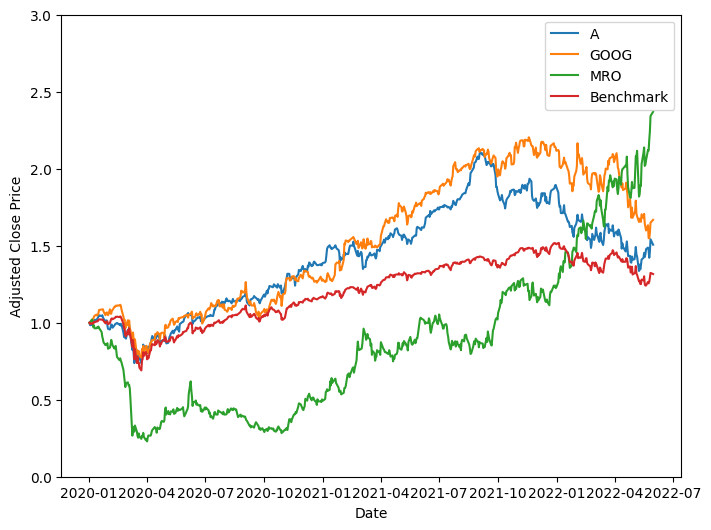

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=asset.index, y=asset['A'] / asset['A'][0], label='A', ax=ax)
sns.lineplot(x=asset.index, y=asset['GOOG'] / asset['GOOG'][0], label='GOOG', ax=ax)
sns.lineplot(x=asset.index, y=asset['MRO'] / asset['MRO'][0], label='MRO', ax=ax)
sns.lineplot(x=benchmark.index, y=benchmark / benchmark[0], label='Benchmark', ax=ax)
ax.set(
    xlabel='Date',
    ylabel='Adjusted Close Price',
    ylim=[0, 3]
)
ax.legend()
plt.show()

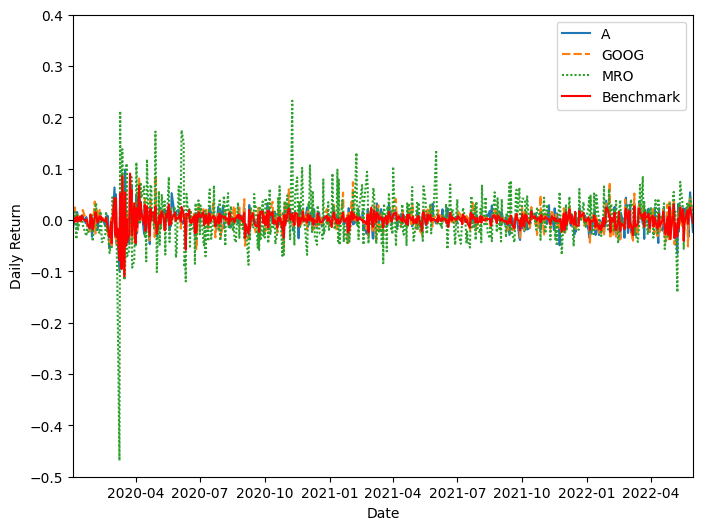

In [4]:
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

r_a.index = pd.to_datetime(r_a.index)
r_b.index = pd.to_datetime(r_b.index)

fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(r_a, ax=ax)
sns.lineplot(r_b, label='Benchmark', c='r', ax=ax)
ax.set(
    xlabel='Date',
    ylabel='Daily Return',
    ylim=[-0.5, 0.4],
    xlim=[r_b.index[0], r_b.index[-1]]
)
ax.legend()
plt.show()

Alpha: [0.00031343 0.00044534 0.00176476]

Beta: [0.95277015 1.05711878 1.39603199]

In [5]:
X = r_b.values
y = r_a.values

X = sm.add_constant(X)
model = regression.linear_model.OLS(y[:, 0], X).fit()
alpha, beta = model.params

In [6]:
print(f'Alpha: {alpha}')
print(f'Beta: {beta}')

Alpha: 0.00031342756538216016
Beta: 0.9527703904597856


In [7]:
start = '2020-01-01'
end = '2022-06-01'

tickers = ['A', 'GOOG', 'MRO']
benchmark = yf.download('SPY', start=start, end=end)['Adj Close']

# Create a DataFrame to store regression results
regression_results = {}

# Perform separate regressions for each asset
for ticker in tickers:
    asset = yf.download(ticker, start=start, end=end)['Adj Close']

    # Calculate returns
    returns_asset = asset.pct_change().dropna()
    returns_benchmark = benchmark.pct_change().dropna()

    # Combine returns into a DataFrame
    data = pd.concat([returns_benchmark, returns_asset], axis=1).dropna()
    data.columns = ['Benchmark', 'Asset']

    # Define independent variable (benchmark returns) and dependent variable (asset returns)
    X = sm.add_constant(data['Benchmark'])
    y = data['Asset']

    # Fit linear regression model
    model = sm.OLS(y, X)
    results = model.fit()

    # Store regression results
    regression_results[ticker] = results

# Print summary of regression results for each asset
for ticker, results in regression_results.items():
    print(f"Regression results for {ticker}:")
    print(results.summary())
    print("\n")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Regression results for A:
                            OLS Regression Results                            
Dep. Variable:                  Asset   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     916.0
Date:                Mon, 20 May 2024   Prob (F-statistic):          3.22e-123
Time:                        18:35:52   Log-Likelihood:                 1809.5
No. Observations:                 607   AIC:                            -3615.
Df Residuals:                     605   BIC:                            -3606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003     

In [8]:
start = '2022-06-01'
end = []
for i in range(7, 13):
    if i < 10:
        part = f'0{i}'
        end.append(f'2022-{part}-01')
    else:
        part = f'{i}'
        end.append(f'2022-{part}-01')

In [9]:
simulation_results = {}
for e in end:
    tickers = ['A', 'GOOG', 'MRO']
    benchmark = yf.download('SPY', start=start, end=e)['Adj Close']
    ticker_results = []
    for ticker in tickers:
        asset = yf.download(ticker, start=start, end=e)['Adj Close']

        # Calculate returns
        returns_asset = asset.pct_change().dropna()
        returns_benchmark = benchmark.pct_change().dropna()

        # Combine returns into a DataFrame
        data = pd.concat([returns_benchmark, returns_asset], axis=1).dropna()
        data.columns = ['Benchmark', 'Asset']

        # Define independent variable (benchmark returns) and dependent variable (asset returns)
        X = sm.add_constant(data['Benchmark'])
        y = data['Asset']

        # Fit linear regression model
        model = sm.OLS(y, X)
        results = model.fit()
        ticker_results.append([ticker, results])
        # Store regression results
    simulation_results[e] = ticker_results

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
A_alpha, A_beta = regression_results['A'].params
G_alpha, G_beta = regression_results['GOOG'].params
M_alpha, M_beta = regression_results['MRO'].params

print(f'Baseline parameters')
print(f'Agilent: {A_alpha}, {A_beta}')
print(f'Google: {G_alpha}, {G_beta}')
print(f'Marathon Oil: {M_alpha}, {M_beta}')

Baseline parameters
Agilent: 0.00031342756538216016, 0.9527703904597856
Google: 0.0004453379380120301, 1.0571182823327143
Marathon Oil: 0.0017647559926655214, 1.3960308121424518


According to the tutorial, you want beta to be within some threshold or if you were to use the parameters and employ regression again, beta should converge to zero.

In [11]:
tickers = ['A']
benchmark = yf.download('SPY', start=start, end=e)['Adj Close']
asset = yf.download(ticker, start=start, end=e)['Adj Close']

r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

P = -1 * A_beta * r_b + r_a
P = P.values
X = sm.add_constant(r_b.values)
fit_model = sm.OLS(P, X).fit()
alpha, beta = fit_model.params
print(f'\nOld beta: {A_beta}')
print(f'New beta: {beta}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Old beta: 0.9527703904597856
New beta: -0.030380190453938527


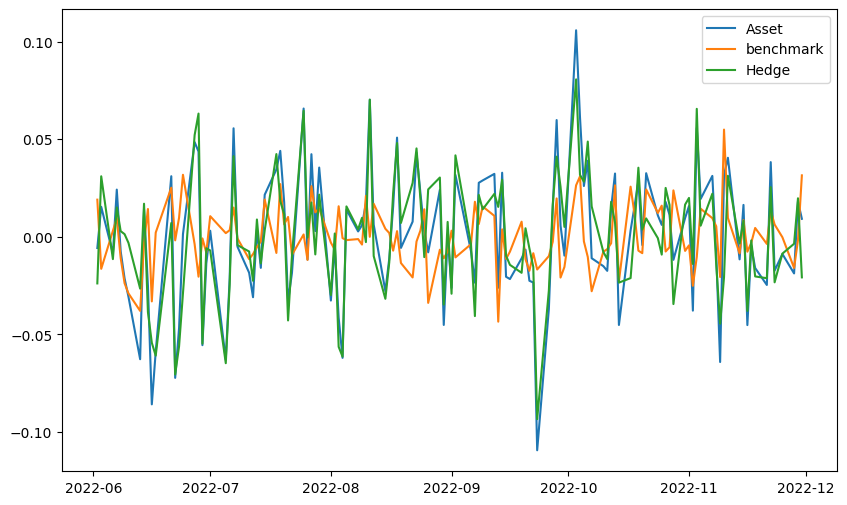

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(r_a, label='Asset')
plt.plot(r_b, label='benchmark')
plt.plot(r_a.index, P, label='Hedge')
plt.legend()
plt.show()

In [13]:
print('Means', r_a.mean(), P.mean())
print('Volatilities', r_a.std(), P.std())

Means 0.00043961807657802134 0.00029230450212682364
Volatilities 0.03417294937929349 0.030753585335866144


In [14]:
import scipy.stats as stats
m1 = r_b.mean()
m2 = P.mean()

alpha = 0.05
t_stat, pvalue = stats.ttest_1samp(P, m1)
if pvalue < alpha:
    print(f'Reject Null hypothesis')
else:
    print(f'Cannot reject null hypothesis')

Cannot reject null hypothesis


In [15]:
# Agilent
agilent_returns = {}
start = '2022-06-01'
end = []

for i in range(7, 13):
    if i < 10:
        part = f'0{i}'
        end.append(f'2022-{part}-01')
    else:
        part = f'{i}'
        end.append(f'2022-{part}-01')

for idx, e in enumerate(end):
    if idx > 0:
        start = end[idx - 1]
        ticker = 'A'
        benchmark = yf.download('SPY', start=start, end=e)['Adj Close']
        asset = yf.download(ticker, start=start, end=e)['Adj Close']

        # Calculate returns
        returns_asset = asset.pct_change()[1:]
        returns_benchmark = benchmark.pct_change()[1:]

        vals = pd.concat([returns_benchmark, returns_asset], axis=1)
        vals.columns = ['Benchmark', 'Asset']
        agilent_returns[start] = vals
    else:
        ticker = 'A'
        benchmark = yf.download('SPY', start=start, end=e)['Adj Close']
        asset = yf.download(ticker, start=start, end=e)['Adj Close']

        # Calculate returns
        returns_asset = asset.pct_change()[1:]
        returns_benchmark = benchmark.pct_change()[1:]

        vals = pd.concat([returns_benchmark, returns_asset], axis=1)
        vals.columns = ['Benchmark', 'Asset']
        agilent_returns[start] = vals

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
def plot_returns(dates, h_beta):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, sharey=True, layout='constrained', figsize=(22, 8)
    )
    for i in range(2):
        for j in range(3):
            date = dates[j]
            if i < 1:
                x_vals = agilent_returns[date]['Benchmark']
                y_vals = agilent_returns[date]['Asset']
                p = (-1 * h_beta) * x_vals + y_vals
                model = sm.OLS(p, sm.add_constant(x_vals)).fit()
                yhat = model.params[0] + x_vals * model.params[1]
                ax[i][j].plot(x_vals)
                ax[i][j].plot(y_vals)
                ax[i][j].plot(p)
                if j < 1:
                    ax[i][j].set(
                        xlabel='Date',
                        ylabel='Returns',
                        ylim=[-0.08, 0.08],
                        xlim=[y_vals.index[0], y_vals.index[-1]],
                        title=f'{date} // Beta: {model.params[1]:04f}'
                    )
                    ax[i][j].legend(['SPY', 'A', 'Portfolio'])
                else:
                    ax[i][j].set(
                        xlabel='Date',
                        xlim=[y_vals.index[0], y_vals.index[-1]],
                        title=f'{date} // Beta: {model.params[1]:04f}'
                    )
            else:
                offset = j + 3
                date = dates[offset]
                x_vals = agilent_returns[date]['Benchmark']
                y_vals = agilent_returns[date]['Asset']
                p = (-1 * h_beta) * x_vals + y_vals
                model = sm.OLS(p, sm.add_constant(x_vals)).fit()
                yhat = model.params[0] + x_vals * model.params[1]
                ax[i][j].plot(x_vals)
                ax[i][j].plot(y_vals)
                ax[i][j].plot(p)
                if j < 1:
                    ax[i][j].set(
                        xlabel='Date',
                        ylabel='Returns',
                        ylim=[-0.08, 0.08],
                        xlim=[y_vals.index[0], y_vals.index[-1]],
                        title=f'{date} // Beta: {model.params[1]:04f}'
                    )
                else:
                    ax[i][j].set(
                        xlabel='Date',
                        xlim=[y_vals.index[0], y_vals.index[-1]],
                        title=f'{date} // Beta: {model.params[1]:04f}'
                    )
    plt.show()

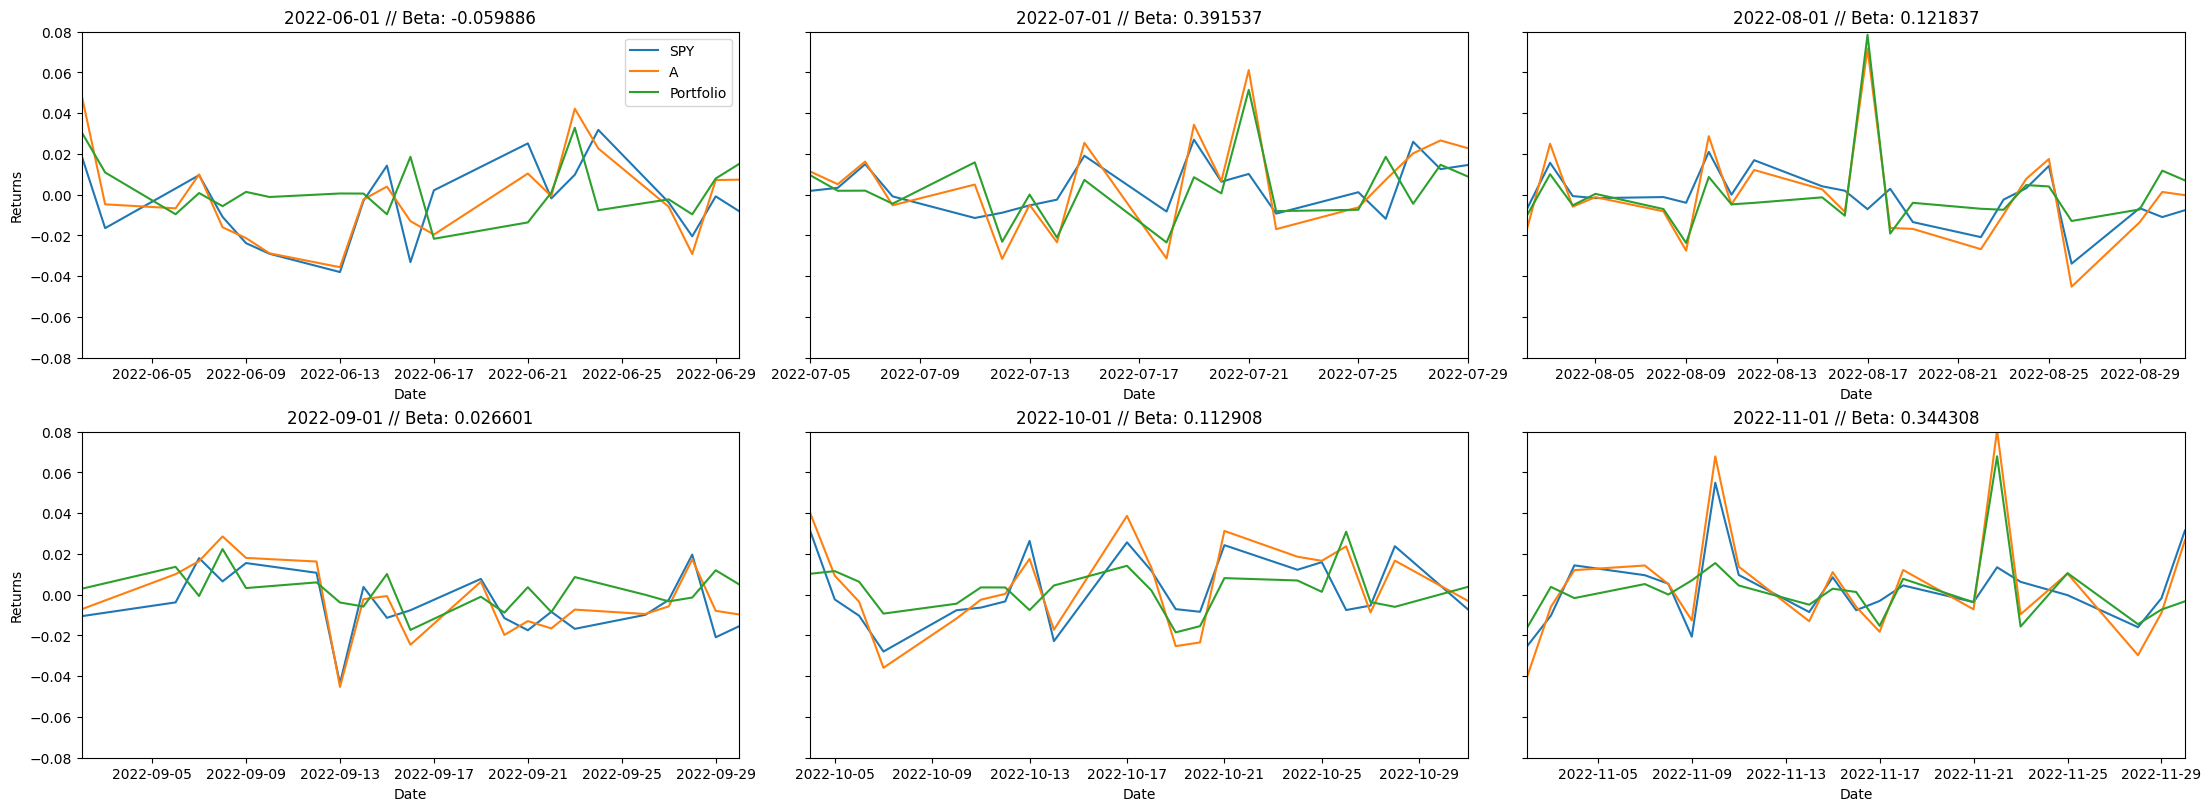

In [17]:
h_beta = regression_results['A'].params[1]
dates = list(agilent_returns.keys())
plot_returns(dates, h_beta)

In [18]:
def linreg(X, y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params

linreg(r_b, r_a)

const        0.000297
Adj Close    0.922390
dtype: float64

In [19]:
h_beta = regression_results['A'].params[1]
print(f'Historical Beta: {h_beta:0.4f}')
for date in dates:
    r_b, r_a = agilent_returns[date]['Benchmark'], agilent_returns[date]['Asset']
    alpha, beta = linreg(r_b, r_a)
    print(f'Date: {date}, out of sample beta: {beta:0.4f}')
    p = (-1 * h_beta) * r_b + r_a
    alpha, beta = linreg(r_b, p)
    print(f'Out of sample portfolio beta: {beta:0.4f}\n')

Historical Beta: 0.9528
Date: 2022-06-01, out of sample beta: 0.8929
Out of sample portfolio beta: -0.0599

Date: 2022-07-01, out of sample beta: 1.3443
Out of sample portfolio beta: 0.3915

Date: 2022-08-01, out of sample beta: 1.0746
Out of sample portfolio beta: 0.1218

Date: 2022-09-01, out of sample beta: 0.9794
Out of sample portfolio beta: 0.0266

Date: 2022-10-01, out of sample beta: 1.0657
Out of sample portfolio beta: 0.1129

Date: 2022-11-01, out of sample beta: 1.2971
Out of sample portfolio beta: 0.3443



In [20]:
for i in range(3):
    timeframe = dates[2 * i + 2 - 1]
    print(timeframe, dates[i])

2022-07-01 2022-06-01
2022-09-01 2022-07-01
2022-11-01 2022-08-01


In [21]:
h_beta = regression_results['A'].params[1]
print(f'Historical Beta: {h_beta:0.4f}\n')

for i in range(3):
    offset = 2 * i + 1
    r_a = np.concatenate([agilent_returns[dates[i]]['Asset'], agilent_returns[dates[offset]]['Asset']], axis=0)
    r_b = np.concatenate([agilent_returns[dates[i]]['Benchmark'], agilent_returns[dates[offset]]['Benchmark']], axis=0)
    alpha, beta = linreg(r_b, r_a)
    print(f'Date: {dates[i]} - {dates[offset]}, out of sample beta: {beta:0.4f}')
    p = (-1 * h_beta) * r_b + r_a
    alpha, beta = linreg(r_b, p)
    print(f'Out of sample portfolio beta: {beta:0.4f}\n')

Historical Beta: 0.9528

Date: 2022-06-01 - 2022-07-01, out of sample beta: 1.0198
Out of sample portfolio beta: 0.0671

Date: 2022-07-01 - 2022-09-01, out of sample beta: 1.1084
Out of sample portfolio beta: 0.1556

Date: 2022-08-01 - 2022-11-01, out of sample beta: 1.2245
Out of sample portfolio beta: 0.2718



In [22]:
import scipy.stats as stats

In [23]:
tstat_asset, pvalue_asset = stats.spearmanr(r_b, r_a)
tstat_port, pvalue_port = stats.spearmanr(r_b, p)

In [24]:
print(tstat_asset, tstat_port)

0.766631553358723 0.33684466412770436


In [25]:
print(pvalue_port)

0.029160303810115144
